<h1>scale tests</h1>
  
  Tests to plot performance of ingest state


<h2>prerequisites</h2>

Ensure that indexes exist on the validationState field in all MetadataDocument repositories

<h2>background</h2>

Investigating an approach to determining submission state -- querying mongo for the states of metadata in a submission in order to determine the state of the envelope overall

<h2>approach</h2>

When an envelope is in the different validation states, we determine the state with the following function:

```
if any contained document is Invalid:
  state = Invalid
else if any contained document is Validating:
  state = Validating
else if any contained document is Draft:
  state = Draft
else:
  state = Valid
```

The state tracker currently maintains an in-memory hash-map of all MetadataDocuments in a submission in order to determine the result of the function.

In order to perform this function, in particular determining <font color='blue'>`any contained document is (some-state)`</font>, we'll query the mongo database. The queries will have to be run on each MetadataDocument repository(e.g `/biomaterals`, `/processes`, `/files`, ...)

Defining submission to state check. We can repeatedly check the state of this submission to simulate checks on lots of submissions.

In [0]:
ingest_api_url = "https://api.ingest.dev.data.humancellatlas.org"
submission_id = "5d562ae41c78450008961754"
submission_url = f'{ingest_api_url}/submissionEnvelopes/{submission_id}'


Defining the validation state check function, `StateChecker.val_state_for_submission()`. This functions call out to the dev ingest API's search methods.

In [0]:
import requests
from multiprocessing.dummy import Pool
from functools import reduce

entity_types = ["biomaterials", "projects", "processes", "files", "protocols"]

class StateChecker:
  
  @staticmethod
  def val_state_for_submission(submission_url: str) -> str:
      if is_invalid(submission_url):
          return "INVALID"
      elif is_validating(submission_url):
          return "VALIDATING"
      elif is_draft(submission_url):
          return "DRAFT"
      else:
          return "VALID"
       
  @staticmethod
  def is_invalid(submission_url: str) -> bool:
      return StateChecker.val_check(StateChecker._is_invalid, submission_url)

  @staticmethod
  def is_validating(submission_url: str) -> bool:
      return StateChecker.val_check(StateChecker._is_validating, submission_url)

  @staticmethod
  def is_draft(submission_url: str) -> bool:
      return StateChecker.val_check(StateChecker._is_draft, submission_url)

  @staticmethod  
  def val_check(val_check_fn, submission_url: str) -> bool:
      val_check_fns = list(map(lambda entity_type: StateChecker.curry_val_check(val_check_fn, submission_url, entity_type), entity_types))
      return reduce(
          lambda a, b: lambda: a() or b(),
          val_check_fns
      )()

  @staticmethod
  def _is_invalid(submission_url: str, entity_type: str) -> bool:
      return StateChecker._has_documents_in_state(submission_url, entity_type, "INVALID")

  @staticmethod
  def _is_validating(submission_url: str, entity_type: str) -> bool:
      return StateChecker._has_documents_in_state(submission_url, entity_type, "VALIDATING")

  @staticmethod
  def _is_draft(submission_url: str, entity_type: str) -> bool:
         return StateChecker._has_documents_in_state(submission_url, entity_type, "DRAFT")
    
  @staticmethod
  def curry_val_check(val_fn, submission_url, entity_type):
      return lambda: val_fn(submission_url, entity_type)

  @staticmethod
  def _has_documents_in_state(submission_url: str, entity_type: str, validation_state: str) -> bool:
      st_url = f'{ingest_api_url}/{entity_type}/search/findBySubmissionEnvelopesContainingAndValidationState?envelopeUri={submission_url}&state={validation_state}'
      sr = requests.get(st_url)
      return sr.json()["page"]["totalElements"] > 0

Running and timing the state check for 1 submission

In [58]:
import time

start = time.time()
state = StateChecker.val_state_for_submission(submission_url)
duration = time.time() - start
print(f'Time: {str(duration)} seconds')

Time: 4.231719255447388 seconds


Timing and plotting many parallel state checks. We don't have exact numbers for the amount of parallel submissions we expect but given that analysis can submit up to 100 simultaneously, I set this to 50. Note this times 1 parallel submissions, then 2 parallel, and so on up to 50. 



In [0]:
import time
from multiprocessing.dummy import Pool

submission_states_parallel_fn = lambda num: Pool(num).map(StateChecker.val_state_for_submission, [submission_url] * num)
submission_states_seq_fn = lambda num: [StateChecker.val_state_for_submission(url) for url in [submission_url] * num]

def time_parallel(num_parallel) -> float:
  start = time.time()
  submission_states_parallel_fn(num_parallel)
  return time.time() - start

# get times for 1 to 50 parallel state checks, sampling at 1,10,20,30,40,50
parallel_subs_range = list(range(0,51,10))
parallel_subs_range[0] = 1
times = [time_parallel(i) for i in parallel_subs_range]


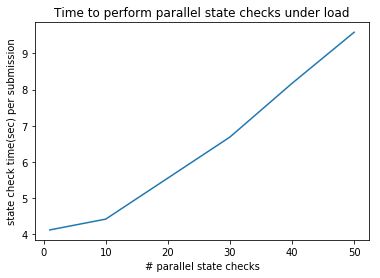

In [63]:
import matplotlib.pyplot as plt

plt.plot(parallel_subs_range, times)

plt.title('Time to perform parallel state checks under load')
plt.xlabel('# parallel state checks')
plt.ylabel('state check time(sec) per submission')

plt.show()